# Kamień milowy 2(feature engineering and baseline)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, SparsePCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster import hierarchy

In [3]:
data = pd.read_csv("data.csv")
X = data.drop(["subject", "Activity", "ActivityName"], axis=1)
y = data["Activity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head()

tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
5538         0.267568        -0.015712        -0.065980       -0.995271   
2755         0.277109        -0.013876        -0.112776       -0.997565   
5813         0.223730        -0.048263        -0.105781       -0.461582   
7506         0.285830        -0.004668        -0.152746       -0.433399   
1334         0.270514        -0.019739        -0.129706       -0.988424   

      tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
5538       -0.977984       -0.963060       -0.996078       -0.980578   
2755       -0.987851       -0.992859       -0.997805       -0.987097   
5813       -0.094674       -0.287821       -0.511609       -0.119351   
7506        0.009730        0.120867       -0.491119        0.047058   
1334       -0.980260       -0.968742       -0.989403       -0.978525   

      tBodyAcc_mad_Z  tBodyAcc_max_X  ...  fBodyBodyGyroJerkMag_meanFreq  \
5538       -0.961130       -0.942153  ...                       0.420093   
2755       -0.994136       -0.942406  ...                       0.545749   
5813       -0.311649       -0.078237  ...                       0.221168   
7506        0.087327       -0.151067  ...                      -0.000990   
1334       -0.967611       -0.933788  ...                       0.342991   

      fBodyBodyGyroJerkMag_skewness  fBodyBodyGyroJerkMag_kurtosis  \
5538                      -0.616825                      -0.794250   
2755                      -0.785950                      -0.956767   
5813                      -0.175540                      -0.545833   
7506                      -0.107975                      -0.507438   
1334                      -0.547240                      -0.800976   

      angletBodyAccMean_gravity  angletBodyAccJerkMean_gravityMean  \
5538                  -0.004331                           0.212652   
2755                  -0.041486                           0.331615   
5813                   0.307722                           0.490644   
7506                  -0.310129                           0.097989   
1334                   0.001274                          -0.359362   

      angletBodyGyroMean_gravityMean  angletBodyGyroJerkMean_gravityMean  \
5538                       -0.370062                           -0.352681   
2755                        0.036768                            0.112289   
5813                       -0.842834                           -0.607873   
7506                        0.527328                           -0.689166   
1334                        0.041658                           -0.338905   

      angleX_gravityMean  angleY_gravityMean  angleZ_gravityMean  
5538           -0.837084            0.099222           -0.101149  
2755           -0.872126            0.009535            0.043758  
5813           -0.854541            0.180849           -0.041994  
7506           -0.306913            0.303946            0.452417  
1334           -0.791197            0.139212            0.162886  

[5 rows x 561 columns]

## Feature engineering 

In [4]:
def drop_correlated(X, threshold=0.97):
    corr_df = X.corr().abs()
    columns_to_leave = np.ones((corr_df.shape[0], 1), dtype=bool)
    for i in range(corr_df.shape[0]):
        if columns_to_leave[i]:
            for j in range(i+1, corr_df.shape[0]):
                if corr_df.iloc[i, j] >= threshold:
                    columns_to_leave[j] = False
    columns_to_leave =  columns_to_leave.reshape(1, corr_df.shape[0])[0]
    return X.loc[:, columns_to_leave]

In [5]:
X_train = drop_correlated(X_train)
X_train.head()

tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
5538         0.267568        -0.015712        -0.065980       -0.995271   
2755         0.277109        -0.013876        -0.112776       -0.997565   
5813         0.223730        -0.048263        -0.105781       -0.461582   
7506         0.285830        -0.004668        -0.152746       -0.433399   
1334         0.270514        -0.019739        -0.129706       -0.988424   

      tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_max_Y  tBodyAcc_max_Z  \
5538       -0.977984       -0.963060       -0.550491       -0.789656   
2755       -0.987851       -0.992859       -0.564823       -0.822405   
5813       -0.094674       -0.287821       -0.129826       -0.334681   
7506        0.009730        0.120867       -0.146341       -0.294388   
1334       -0.980260       -0.968742       -0.567375       -0.810410   

      tBodyAcc_min_X  tBodyAcc_min_Y  ...  fBodyBodyGyroJerkMag_min  \
5538        0.843383        0.691476  ...                 -0.995824   
2755        0.846542        0.691177  ...                 -0.999933   
5813        0.386962        0.081401  ...                 -0.909415   
7506        0.424646        0.031001  ...                 -0.495843   
1334        0.836722        0.682680  ...                 -0.996252   

      fBodyBodyGyroJerkMag_iqr  fBodyBodyGyroJerkMag_maxInds  \
5538                 -0.996387                     -1.000000   
2755                 -0.997907                     -0.523810   
5813                 -0.583603                     -0.904762   
7506                 -0.588718                     -0.904762   
1334                 -0.993925                     -1.000000   

      fBodyBodyGyroJerkMag_meanFreq  fBodyBodyGyroJerkMag_skewness  \
5538                       0.420093                      -0.616825   
2755                       0.545749                      -0.785950   
5813                       0.221168                      -0.175540   
7506                      -0.000990                      -0.107975   
1334                       0.342991                      -0.547240   

      fBodyBodyGyroJerkMag_kurtosis  angletBodyAccMean_gravity  \
5538                      -0.794250                  -0.004331   
2755                      -0.956767                  -0.041486   
5813                      -0.545833                   0.307722   
7506                      -0.507438                  -0.310129   
1334                      -0.800976                   0.001274   

      angletBodyAccJerkMean_gravityMean  angletBodyGyroMean_gravityMean  \
5538                           0.212652                       -0.370062   
2755                           0.331615                        0.036768   
5813                           0.490644                       -0.842834   
7506                           0.097989                        0.527328   
1334                          -0.359362                        0.041658   

      angletBodyGyroJerkMean_gravityMean  
5538                           -0.352681  
2755                            0.112289  
5813                           -0.607873  
7506                           -0.689166  
1334                           -0.338905  

[5 rows x 333 columns]

In [6]:
def reshape(components):
    res = np.zeros((2, components.shape[0]))
    for i in range(len(components)):
        res[0][i] = components[i][0]
        res[1][i] = components[i][1]
    return res

def get_components(model, X, perplexity=None):
    transformer = None 
    if model == "PCA":
        transformer = PCA(n_components = 2)
    elif model == "TSNE":
        if perplexity is None:
            transformer = Pipeline(
                [("pca", PCA(n_components = 60)),
                ("tsne", TSNE(n_components = 2))
                ])
        else:
            transformer = pipeline = Pipeline(
            [("pca", PCA(n_components = 60)),
            ("tsne", TSNE(n_components = 2, 
                          perplexity = perplexity,
                         random_state = 42))
            ])
    
    X_transformed = transformer.fit_transform(X)
    X_transformed = reshape(X_transformed)
    return X_transformed
    
def plot_components(model, X, perplexity=None, labels=None, comp=False, title=True,
                   legend_labels=None):
    X_transformed = None
    if not comp:
        X_transformed = get_components(model, X, perplexity)
    else:
        X_transformed = reshape(X)
    plt.rcParams["figure.figsize"] = [20,15]
    scatter = None
    fig, ax = plt.subplots()
    if labels is not None and legend_labels is None:
        ax.scatter(X_transformed[0], X_transformed[1], c=labels, cmap="coolwarm")
    if labels is None and legend_labels is None:
        ax.scatter(X_transformed[0], X_transformed[1])
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    if title:
        ax.set_title(model)
    if legend_labels is not None:
        for g in np.unique(labels):
            i = np.where(labels == g)
            ax.scatter(X_transformed[0][i], X_transformed[1][i], label=legend_labels[g-1])
        ax.legend()

def choose_best_tsne(X, perplexity=30, iterations=10, pca=True):
    np.random.seed(42)
    random_states = np.random.choice(100, iterations, replace=False)
    best_model = None
    best_score = np.inf
    
    X_transformed = None
    if pca:
        X_transformed = PCA(n_components = 60).fit_transform(X)
    else:
        X_transformed = X
    
    for i in range(iterations):
        tsne = TSNE(n_components = 2, 
                    perplexity = perplexity,
                    random_state = random_states[i])
        tsne.fit(X_transformed)
        if tsne.kl_divergence_ < best_score:
            best_score = tsne.kl_divergence_
            best_model = tsne
    
    return best_model

In [7]:
def plot_metrics(X, pca=True):
    model = KMeans(random_state=0)
    
    metrics = ["silhouette", "calinski_harabasz"]
    
    X_transformed = None
    if pca:
        X_transformed = PCA(n_components = 60).fit_transform(X)
    else:
        X_transformed = X
    
    for i in range(len(metrics)):
        visualizer = KElbowVisualizer(model, 
                              k=(2,10), 
                              metric=metrics[i], 
                              locate_elbow=False,
                              timings=False)
        
        visualizer.fit(X_transformed)
        visualizer.show()
        plt.show()
        

### Bez PCA

In [38]:
best_tsne = choose_best_tsne(X_train, perplexity=50, iterations=1, pca=False)

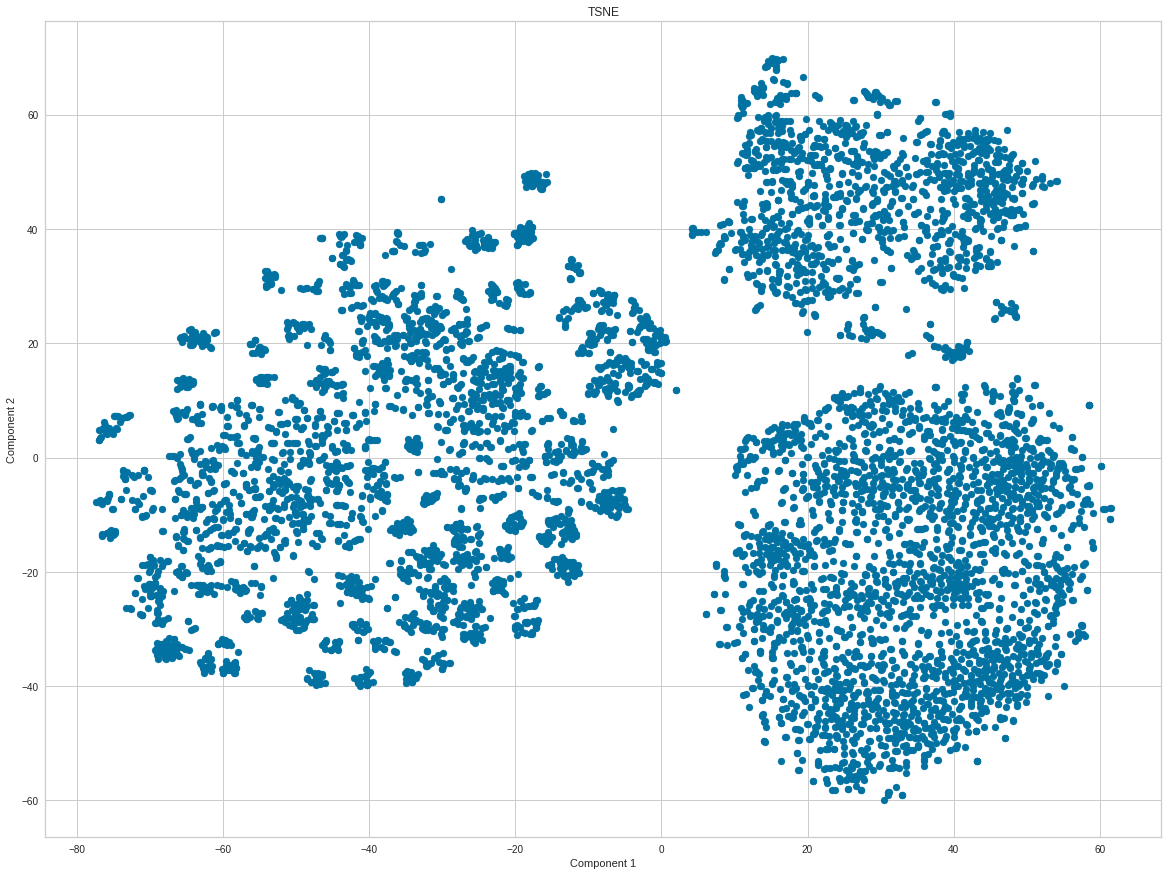

In [39]:
plot_components("TSNE", X=best_tsne.embedding_, comp=True)

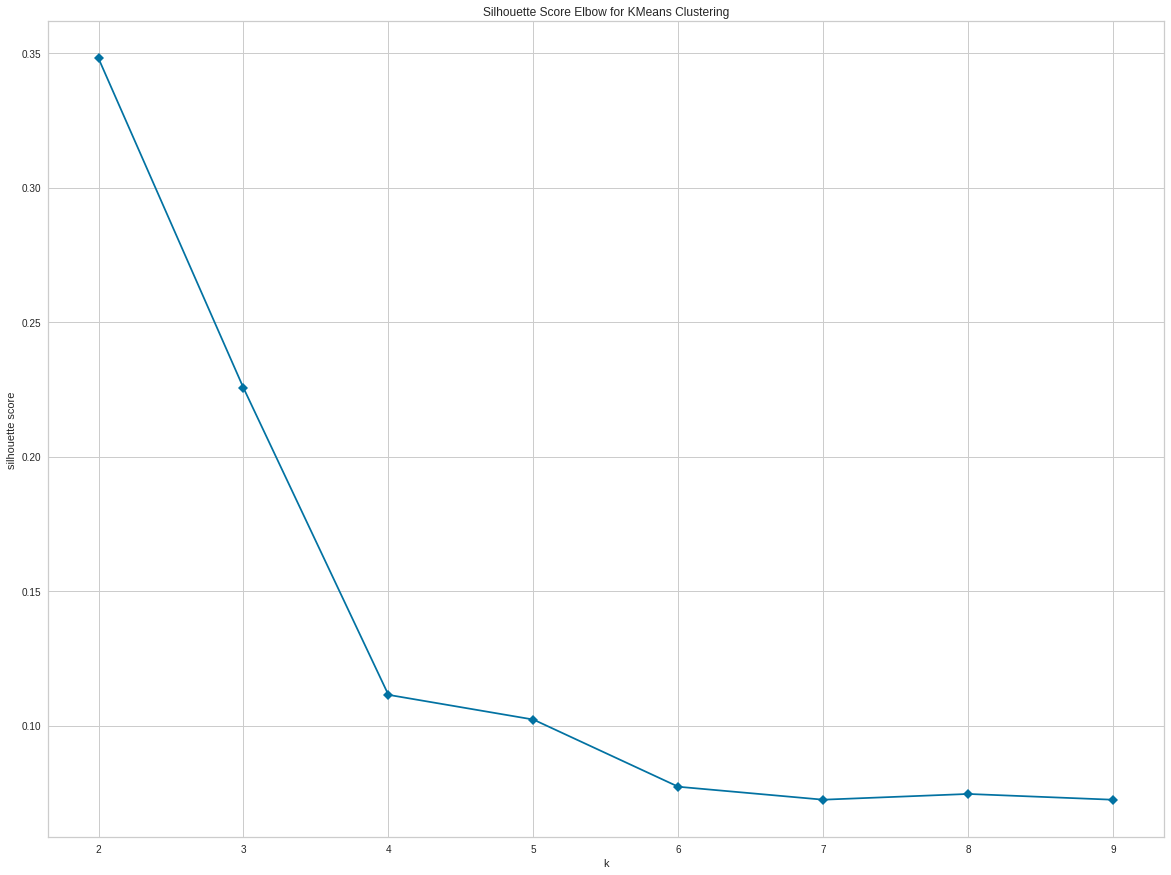

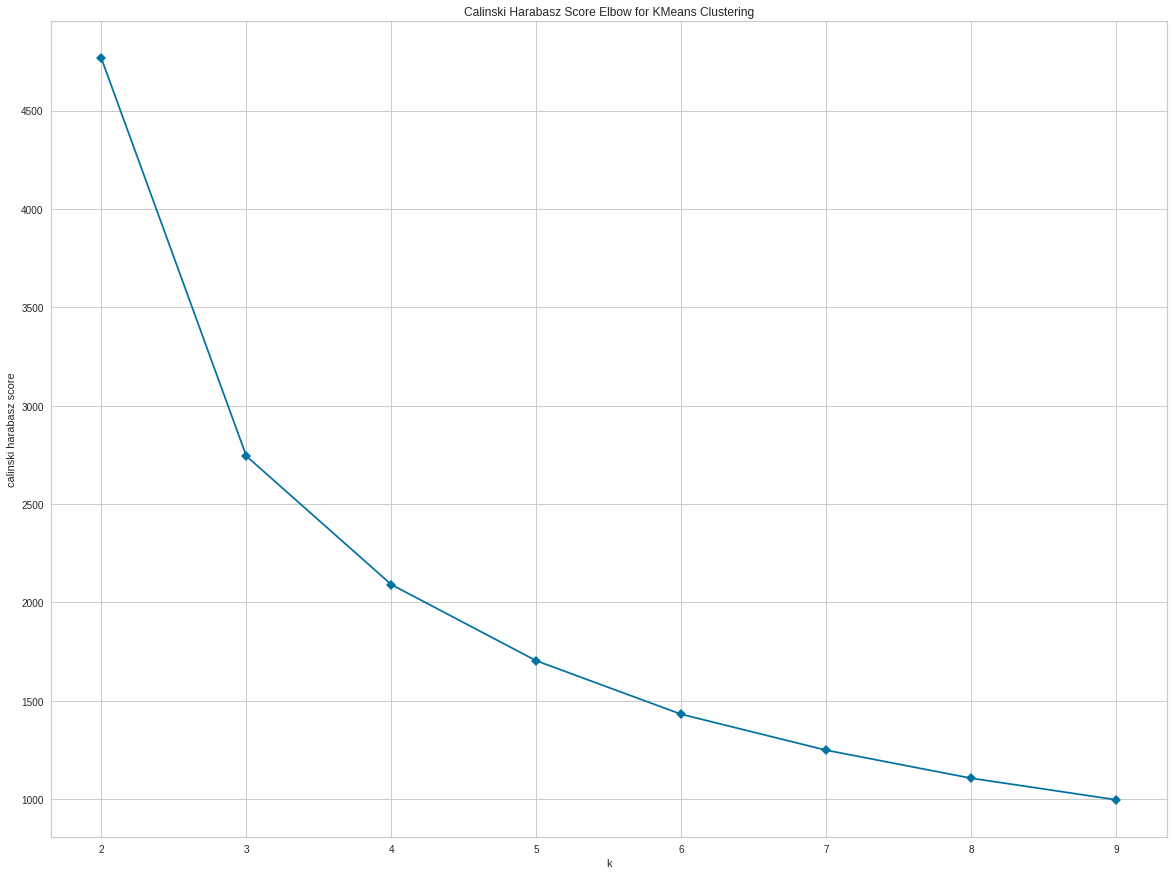

In [10]:
plot_metrics(X_train, pca=False)

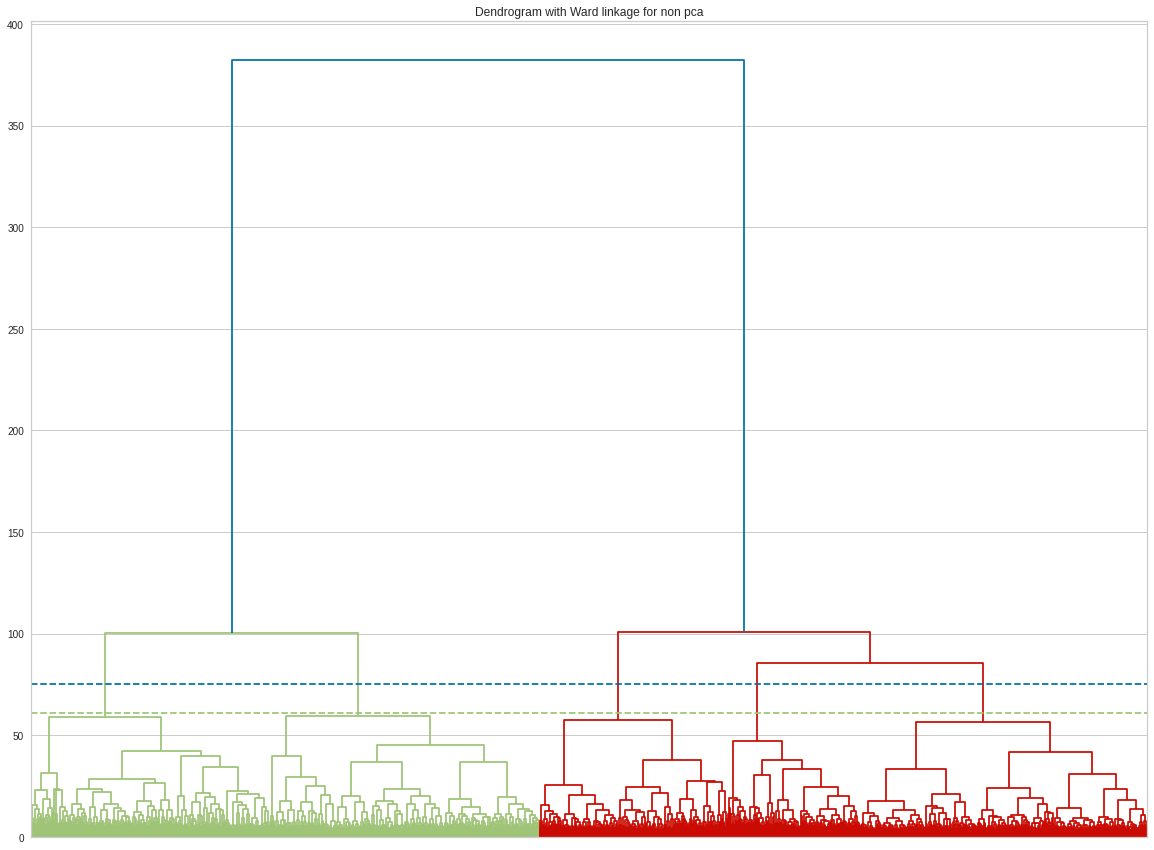

In [12]:
hierarchy.dendrogram(hierarchy.linkage(X_train, method="ward"), 
                     orientation="top")
plt.title("Dendrogram with Ward linkage for non pca")
plt.axhline(y=75, color="b", linestyle="dashed")
plt.axhline(y=61, color="g", linestyle="dashed")
ax = plt.gca()
ax.axes.xaxis.set_visible(False)

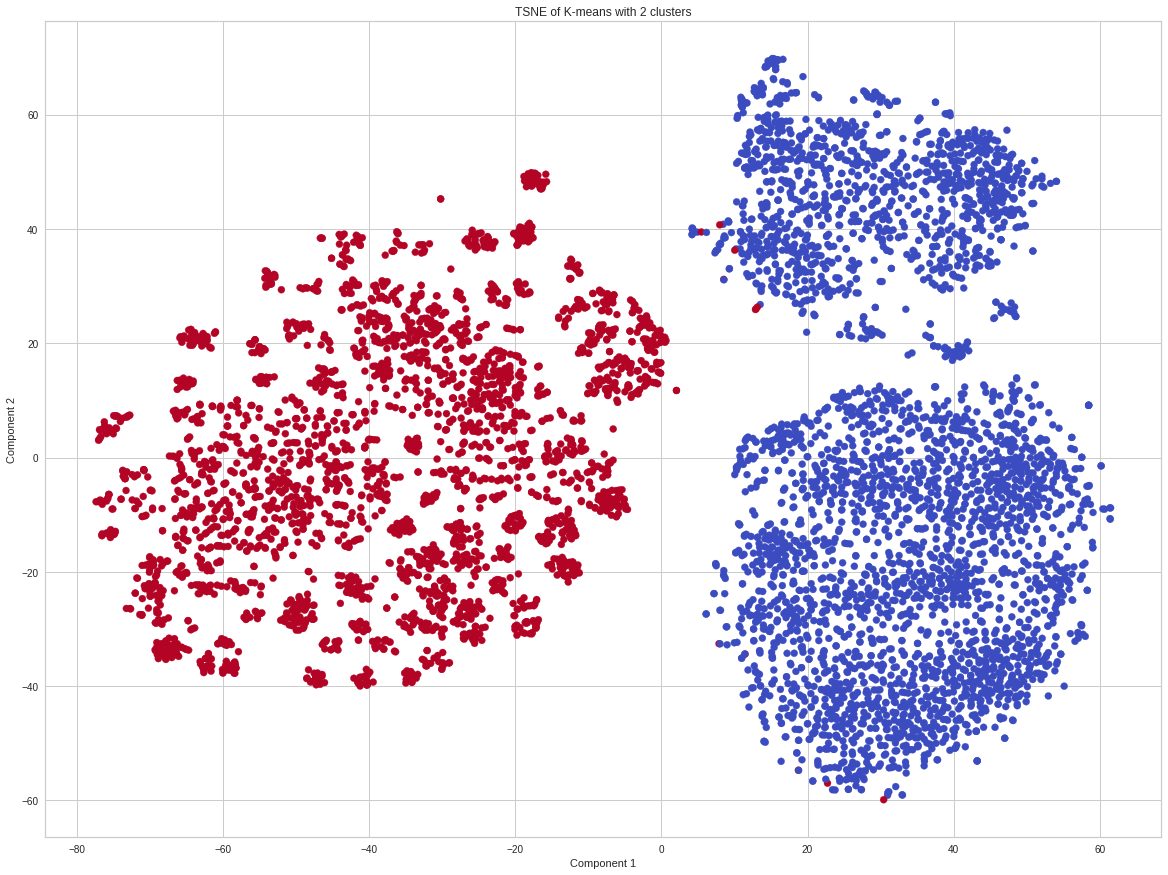

In [40]:
# K-means
model = Pipeline(
                [("k_means", KMeans(n_clusters = 2, random_state = 42)),
                ("agglomerative5", AgglomerativeClustering(n_clusters = 5, 
                                                linkage = "ward"))
                ])
model.fit(X_train)
labels = model["k_means"].labels_
plot_components("TSNE", best_tsne.embedding_, labels=labels, comp=True, title=False)
plt.title("TSNE of K-means with 2 clusters")
plt.show()

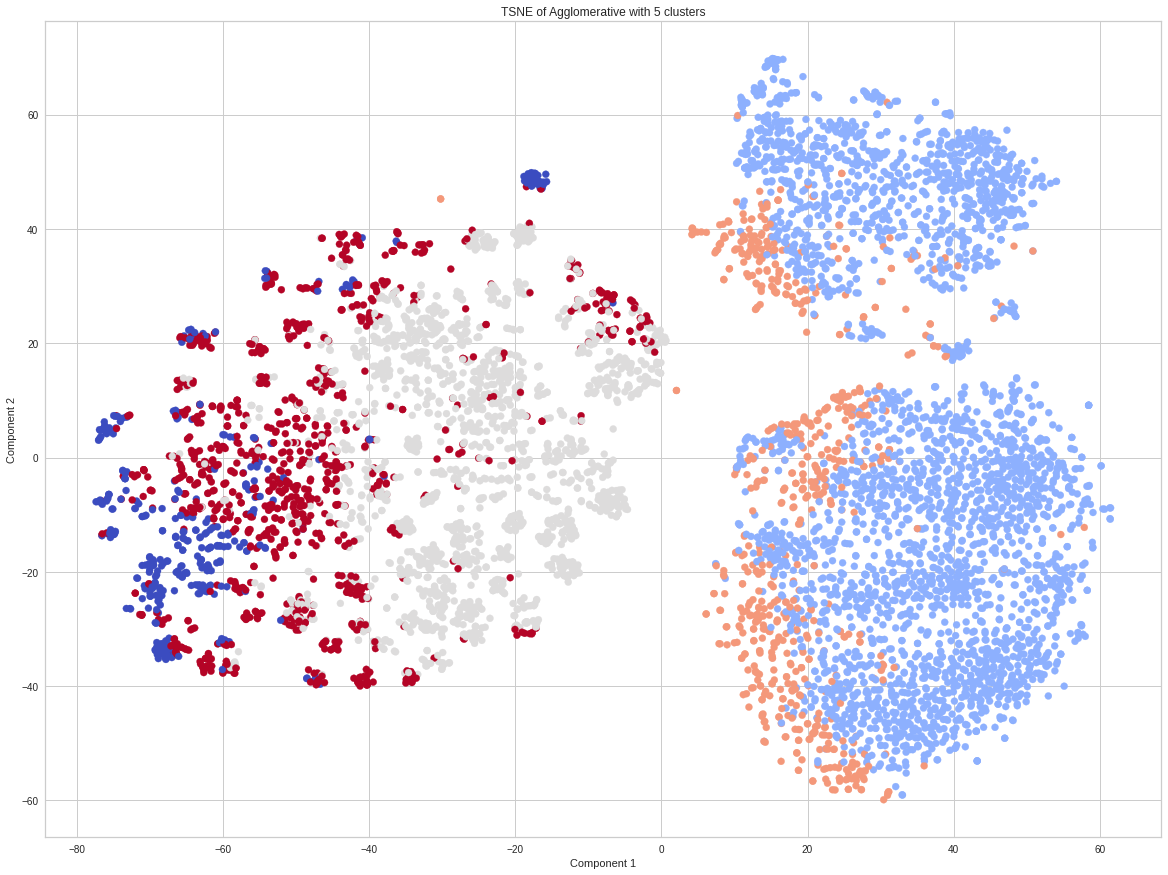

In [41]:
# agglomerative 5 klastrów
labels = model["agglomerative5"].labels_
plot_components("TSNE", best_tsne.embedding_, labels=labels, comp=True, title=False)
plt.title("TSNE of Agglomerative with 5 clusters")
plt.show()

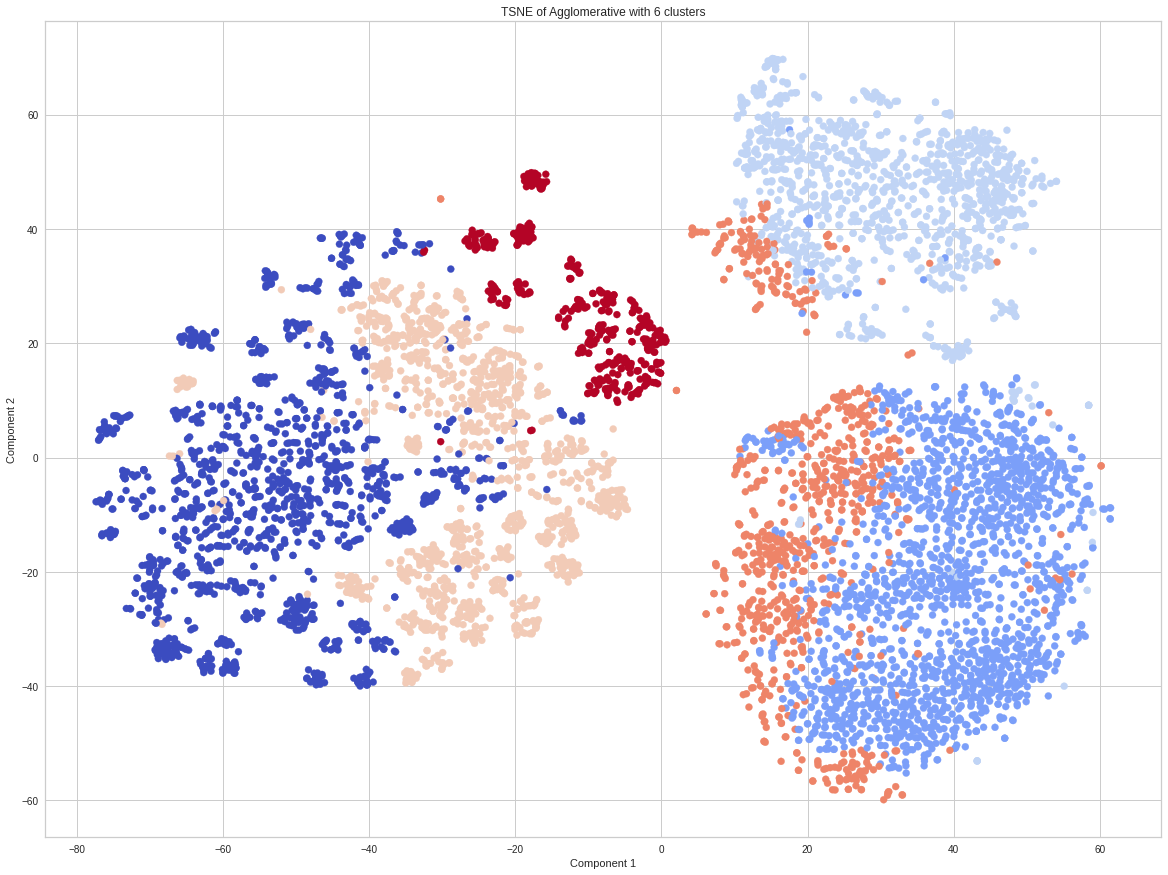

In [42]:
# agglomerative 6 klastrów
model = AgglomerativeClustering(n_clusters = 6, linkage = "ward")
model.fit(X_train)
labels = model.labels_
plot_components("TSNE", best_tsne.embedding_, labels=labels, comp=True, title=False)
plt.title("TSNE of Agglomerative with 6 clusters")
plt.show()

### Z PCA

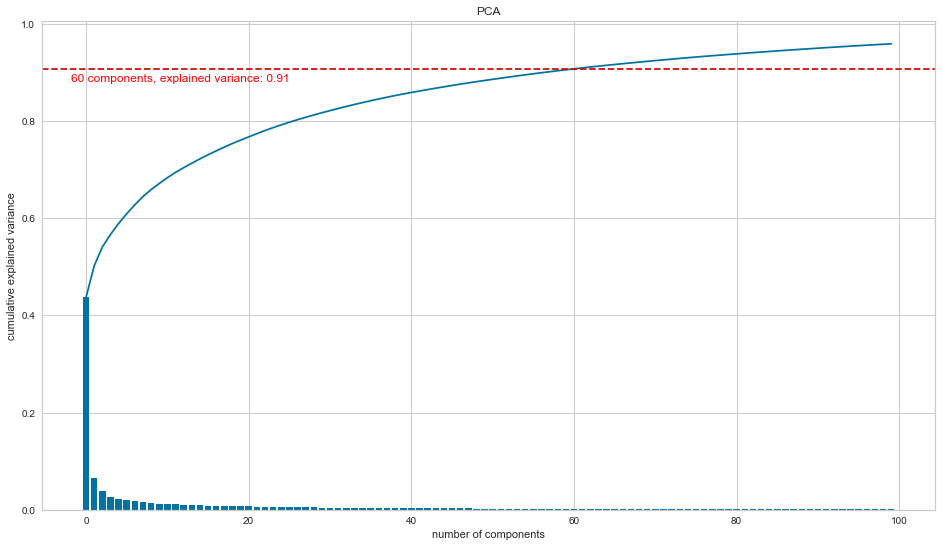

In [7]:
pca = PCA()
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_
n = 100
m = 60
m_comp_explained_variance = np.sum(explained_variance[0:m+1])

plt.rcParams["figure.figsize"] = [16,9]
plt.plot(np.cumsum(explained_variance[0:n]))
plt.bar(np.arange(n), explained_variance[0:n])
plt.axhline(y=m_comp_explained_variance, color="r", linestyle="dashed")
plt.text(25,m_comp_explained_variance-0.02, 
         str(m) + " components, explained variance: " + "{:.2f}".format(m_comp_explained_variance), 
         color="red", 
        ha="right", va="center")
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance");
plt.title("PCA")
plt.show()

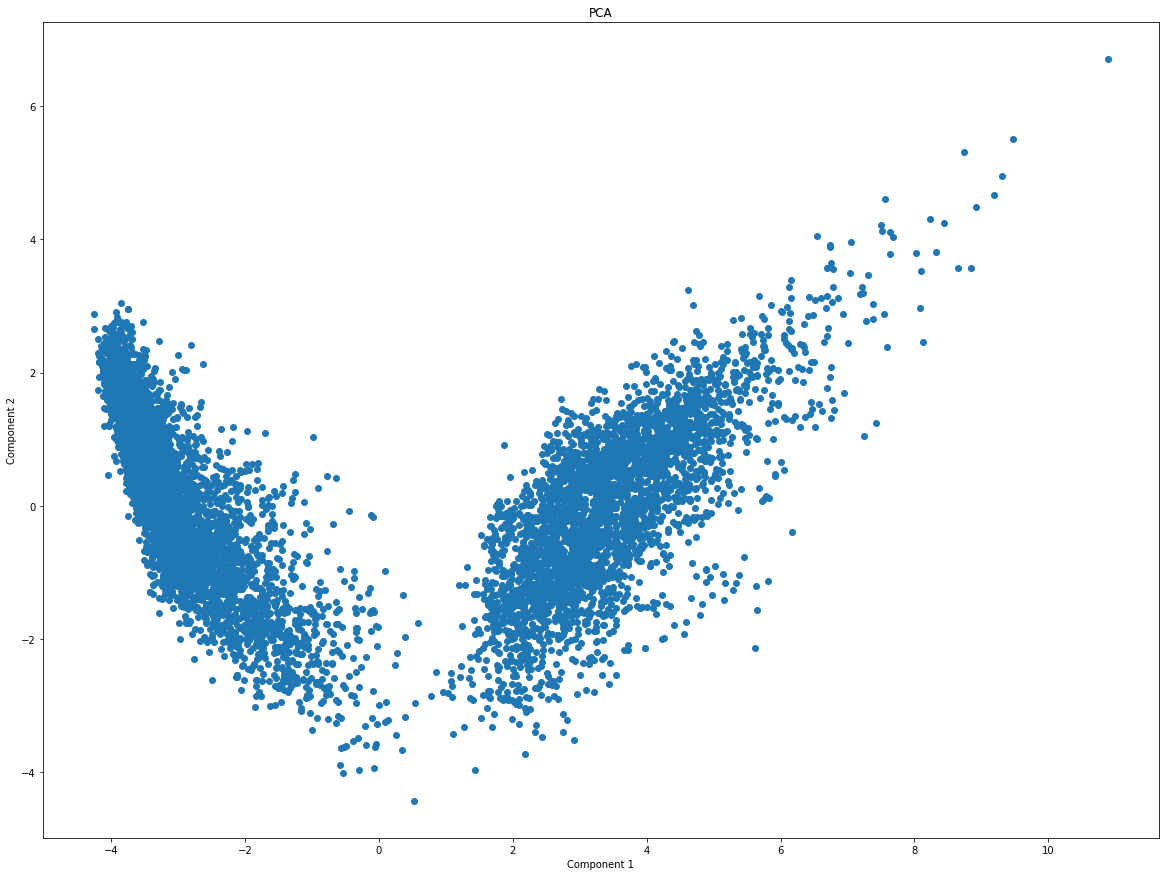

In [67]:
plot_components("PCA", X_train)

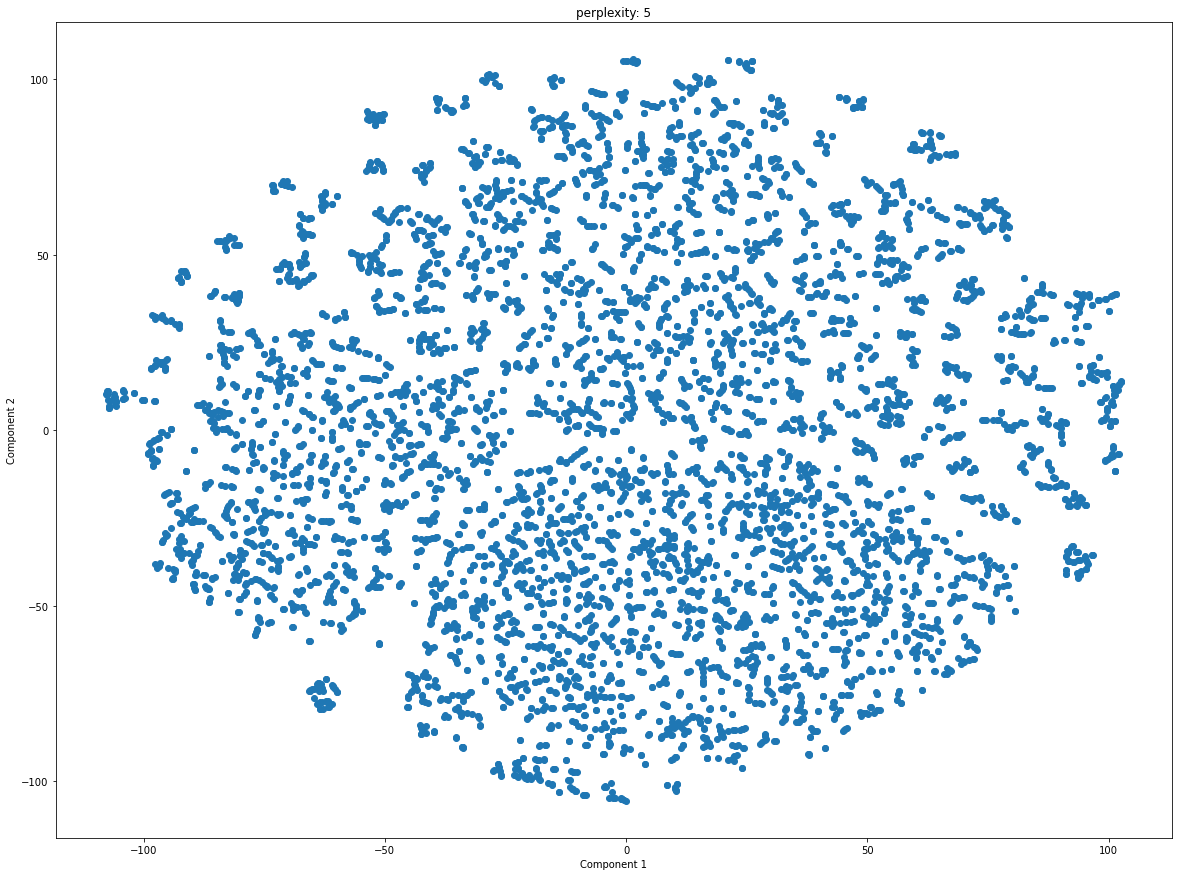

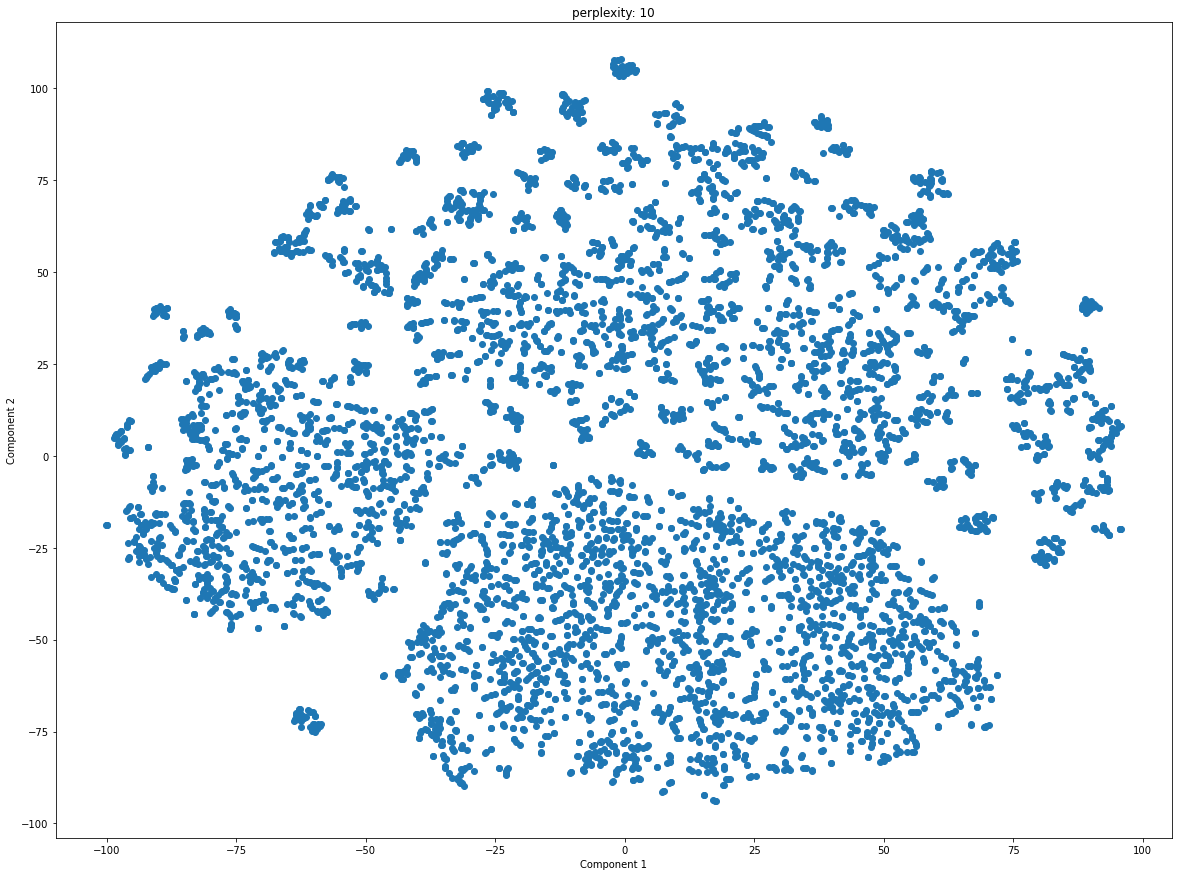

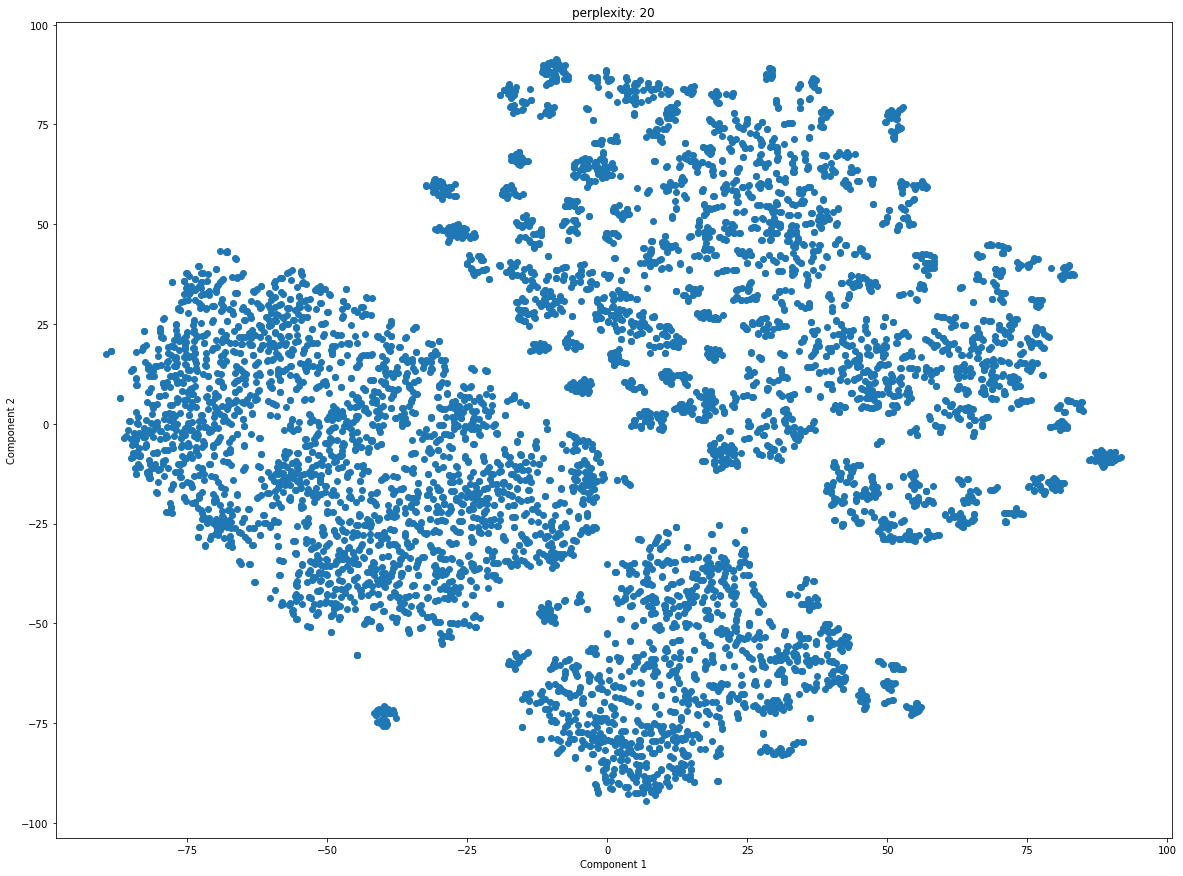

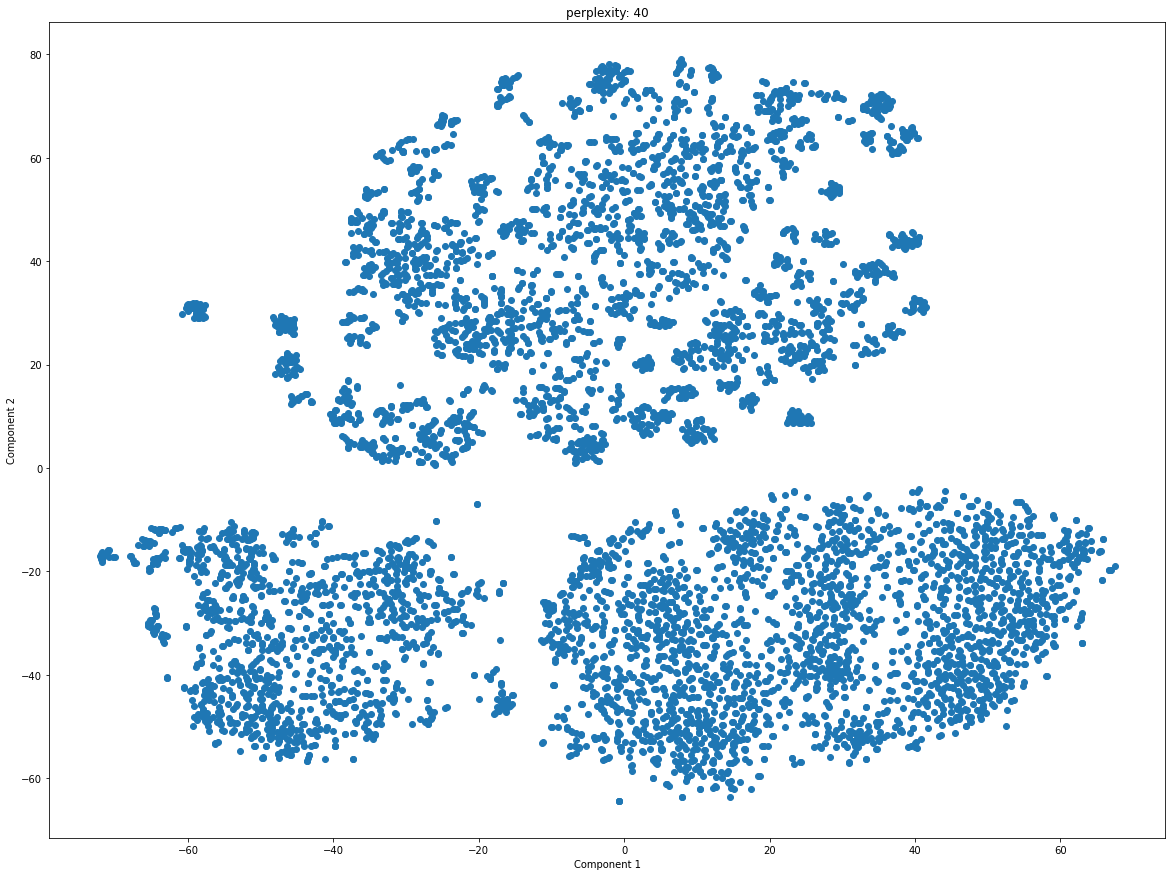

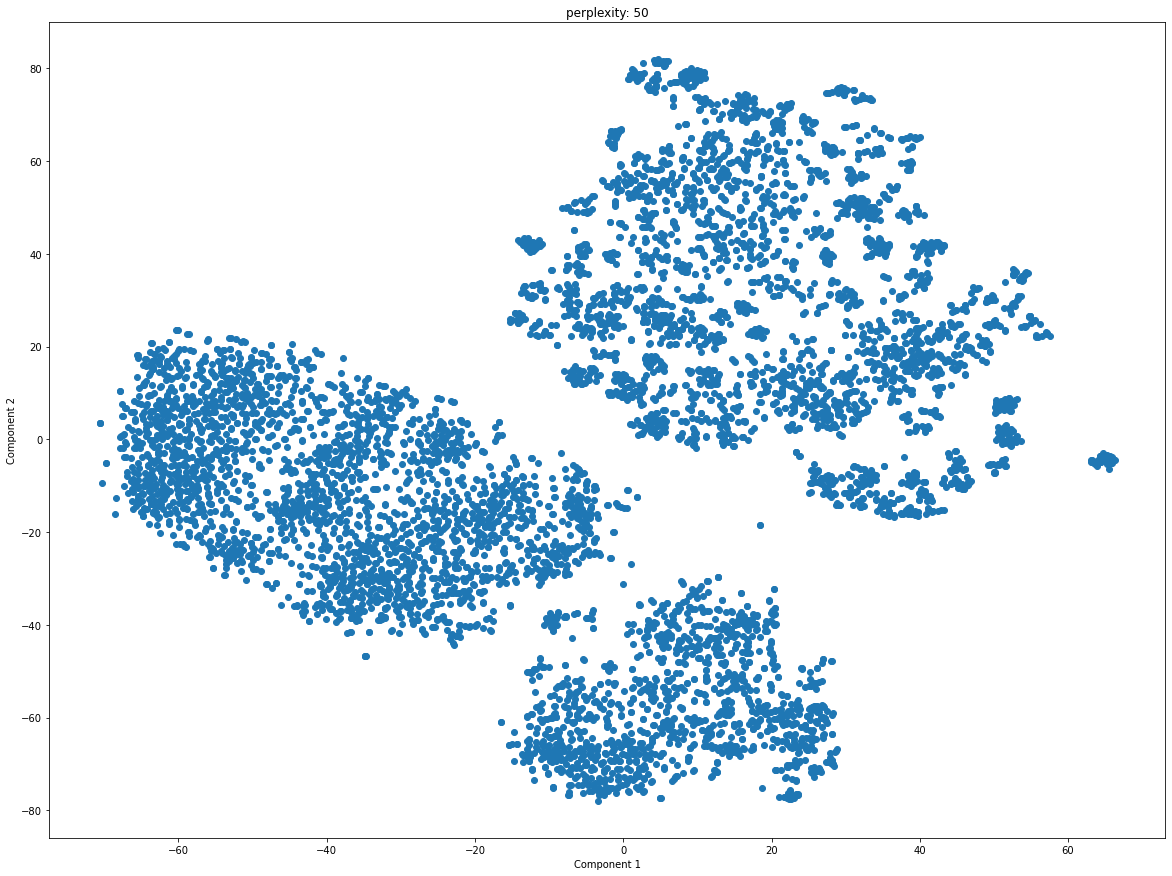

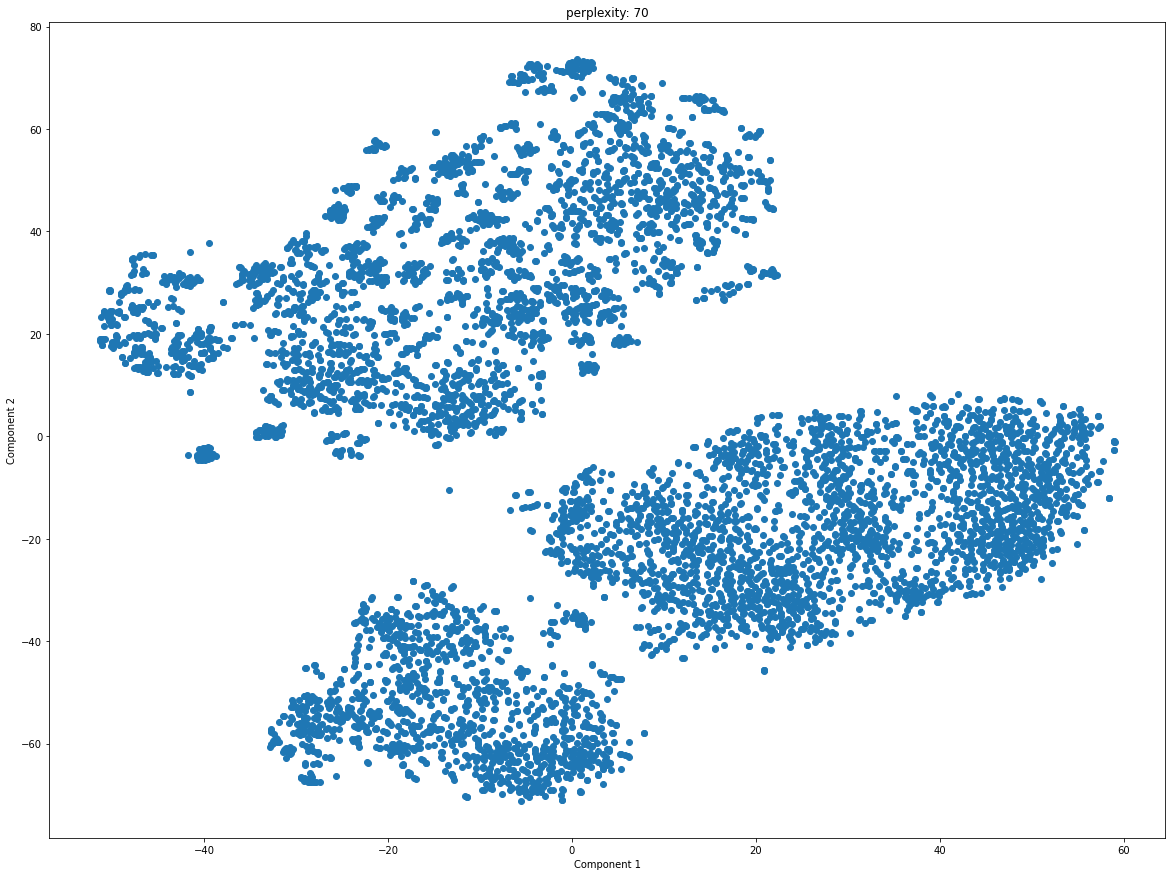

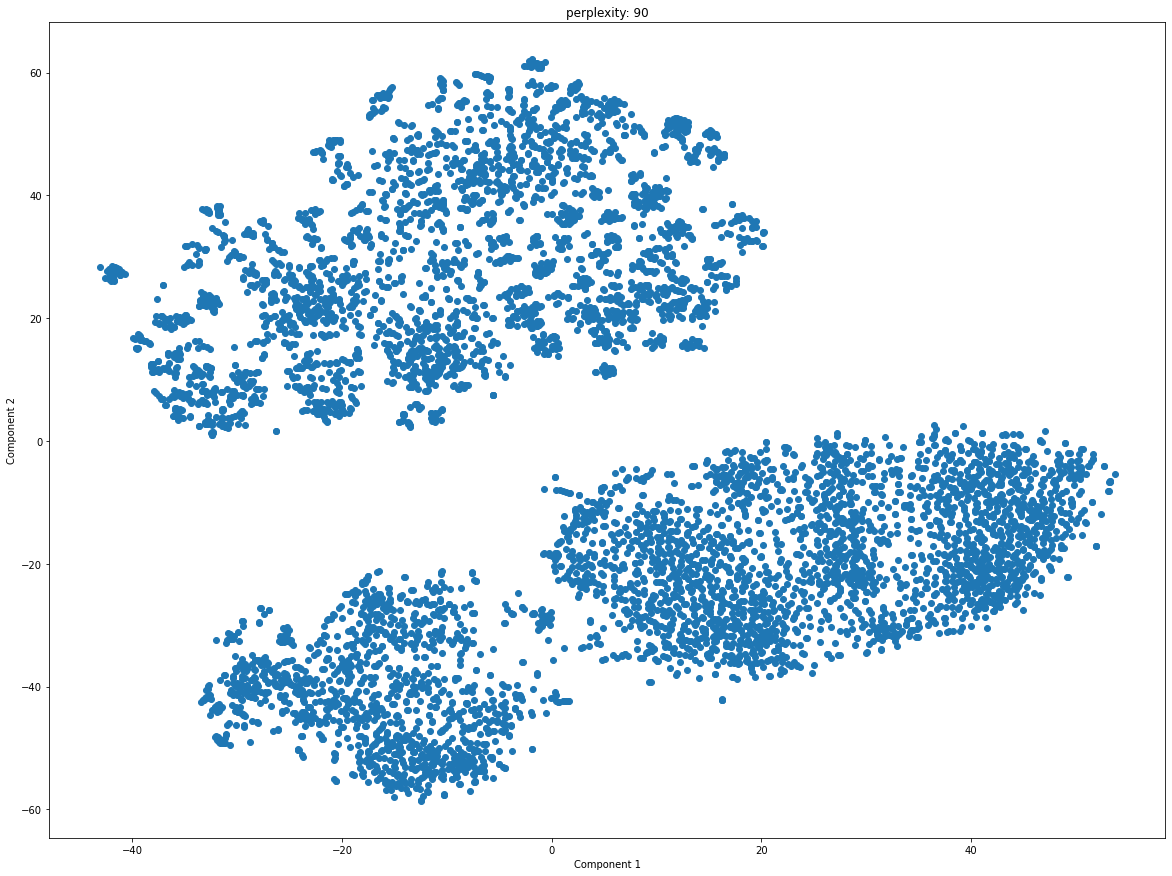

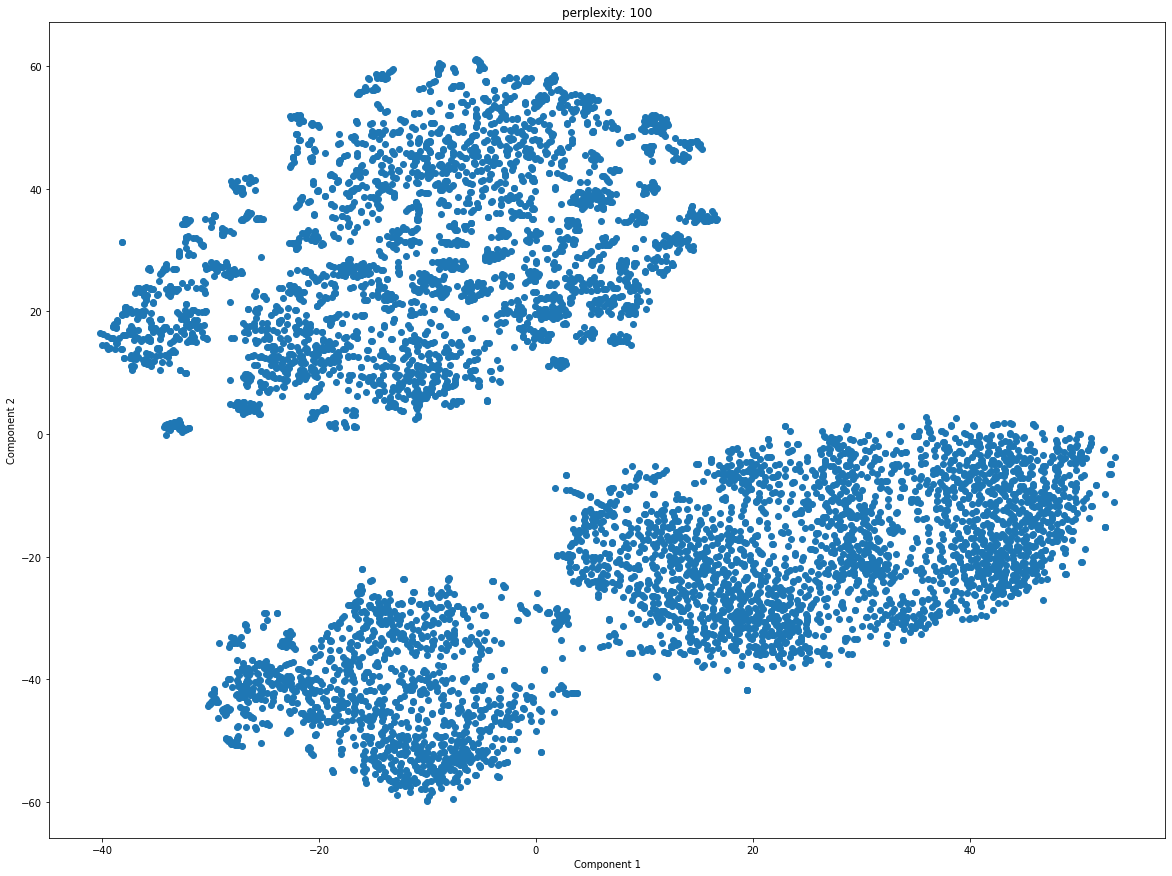

In [60]:
perplexities = [5, 10, 20, 40, 50, 70, 90, 100]

for i in range(len(perplexities)):
        plot_components("TSNE", X_train, perplexity=perplexities[i], title=False)
        plt.title("perplexity: " + str(perplexities[i]))
        plt.show()

In [7]:
best_tsne = choose_best_tsne(X_train, 50)

In [65]:
best_tsne.kl_divergence_

1.5486414432525635

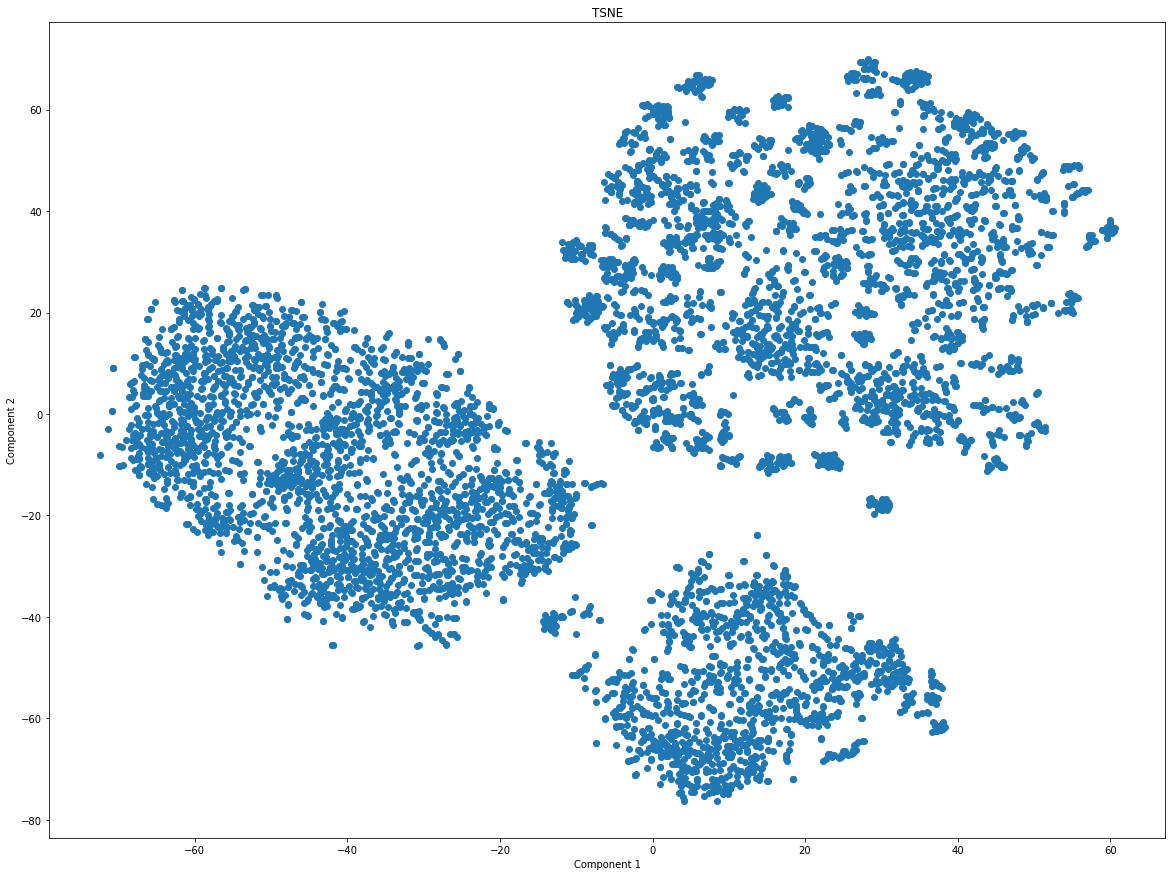

In [66]:
plot_components("TSNE", X=best_tsne.embedding_, comp=True)

## Modeling

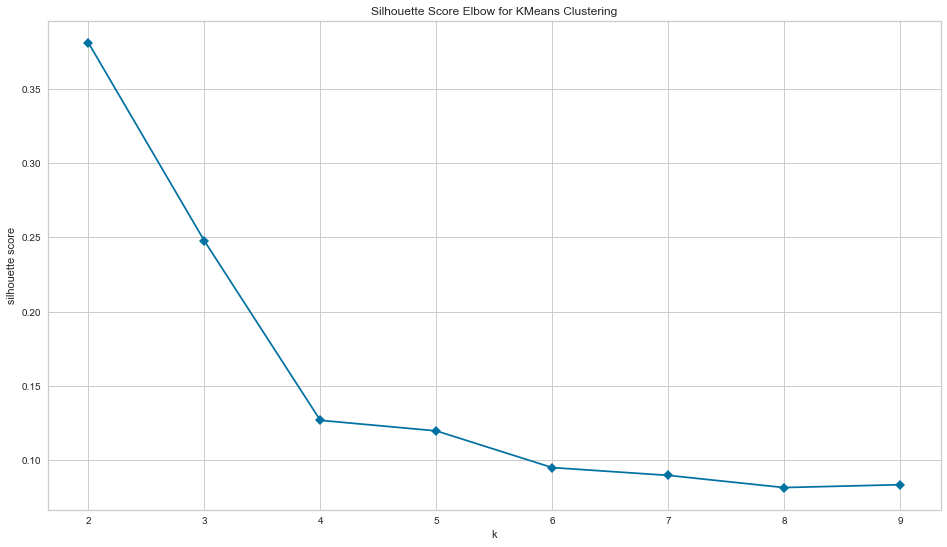

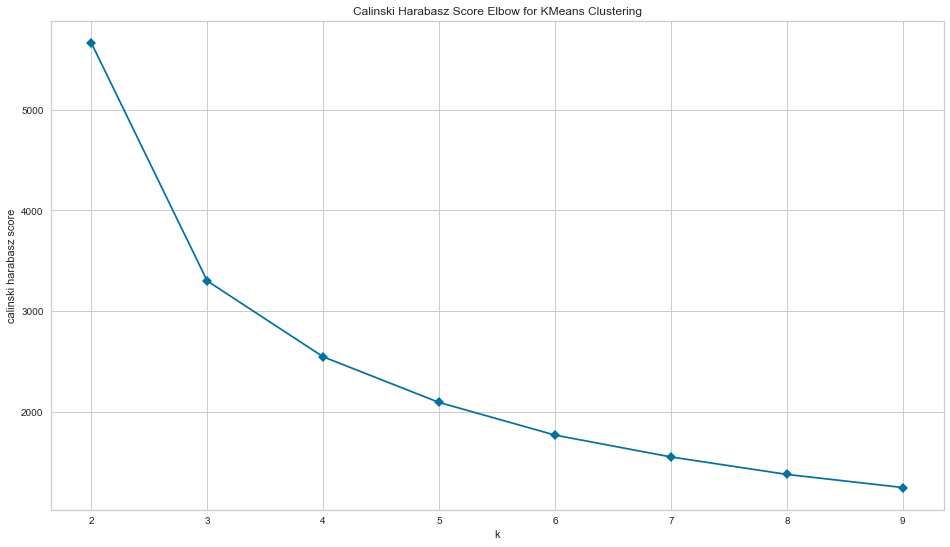

In [98]:
plot_metrics(X_train)

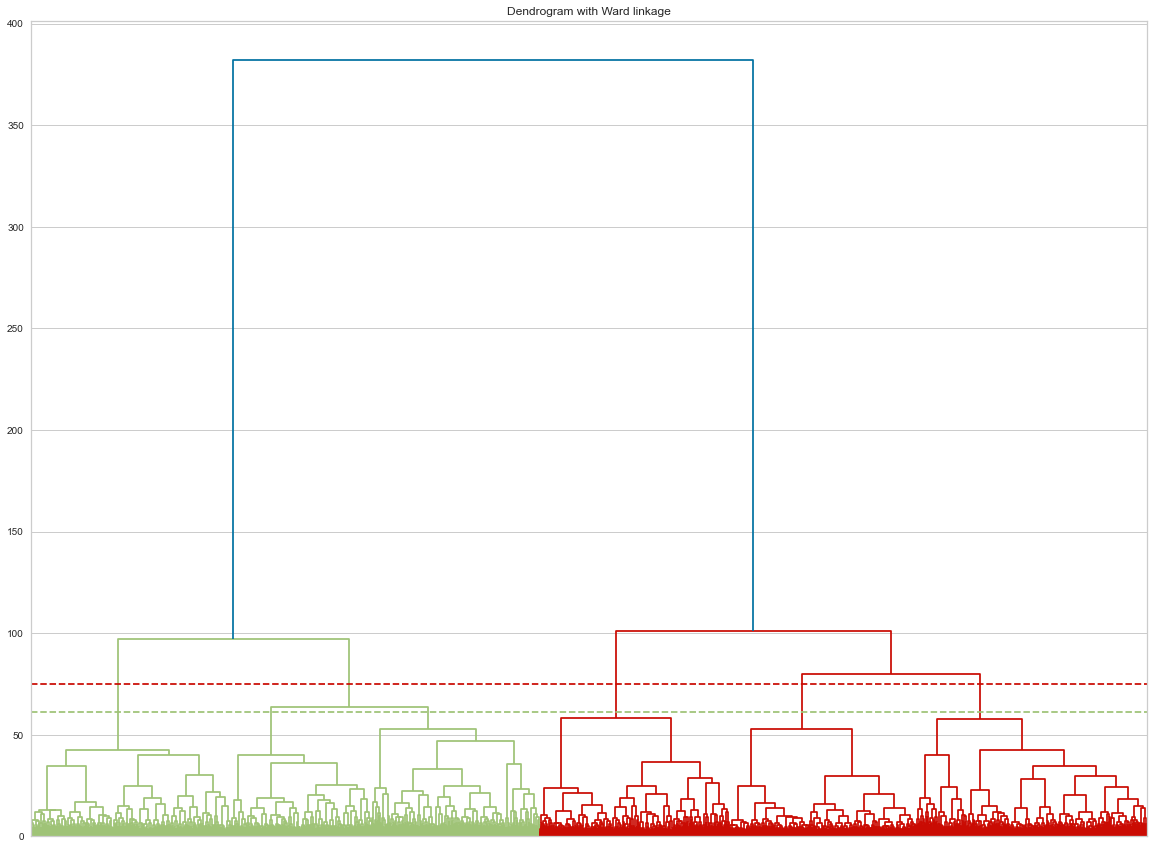

In [68]:
hierarchy.dendrogram(hierarchy.linkage(PCA(n_components = 60, 
                                           random_state = 42).fit_transform(X_train), 
                                       method="ward"), 
                     orientation="top")
plt.title("Dendrogram with Ward linkage")
plt.axhline(y=75, color="r", linestyle="dashed")
plt.axhline(y=61, color="g", linestyle="dashed")
ax = plt.gca()
ax.axes.xaxis.set_visible(False)

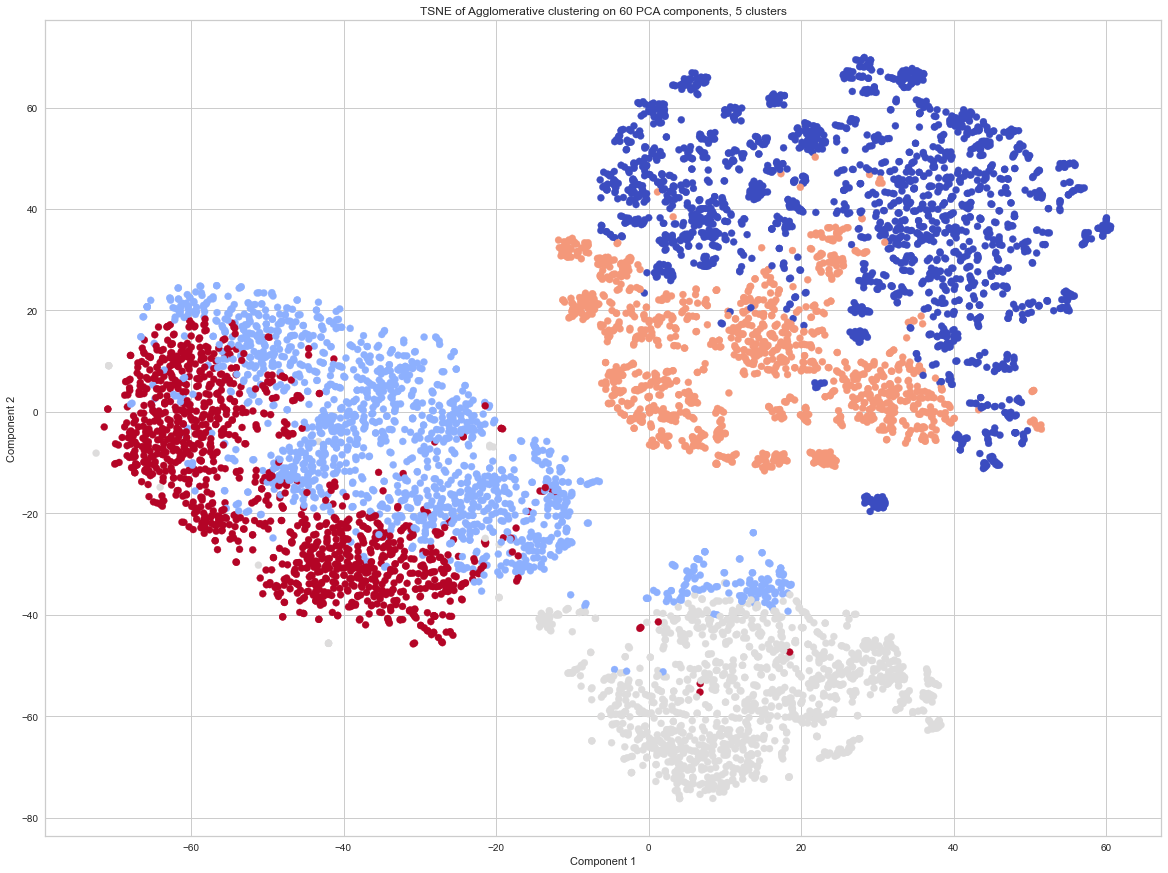

In [69]:
model = Pipeline(
                [("pca", PCA(n_components = 60, random_state = 42)),
                ("agglomerative", AgglomerativeClustering(n_clusters = None, 
                                                linkage = "ward",
                                                distance_threshold = 75))
                ])
model.fit(X_train)
labels = model["agglomerative"].labels_
plot_components("TSNE", best_tsne.embedding_, labels=labels, comp=True, title=False)
plt.title("TSNE of Agglomerative clustering on 60 PCA components, 5 clusters")
plt.show()

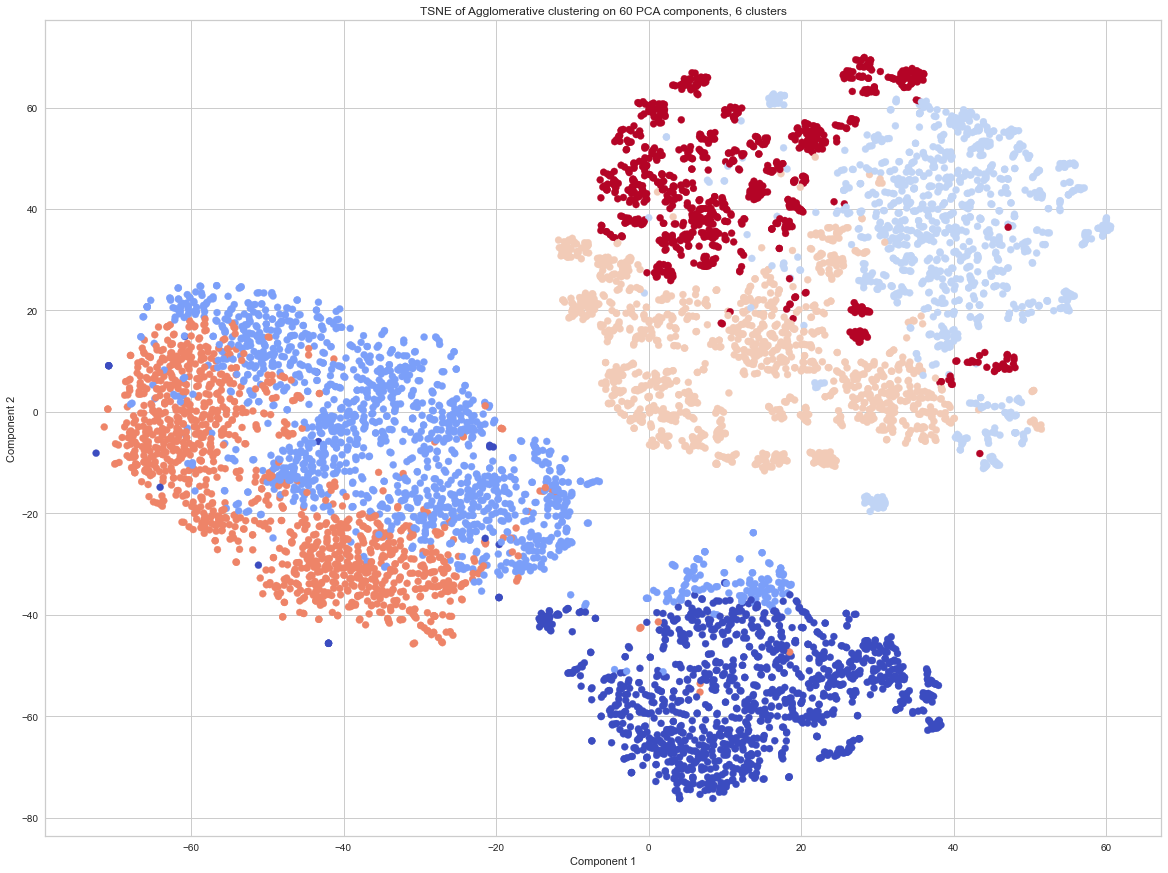

In [76]:
model = Pipeline(
                [("pca", PCA(n_components = 60, random_state = 42)),
                ("agglomerative", AgglomerativeClustering(n_clusters = None, 
                                                linkage = "ward",
                                                distance_threshold = 61))
                ])
model.fit(X_train)
labels = model["agglomerative"].labels_
plot_components("TSNE", best_tsne.embedding_, labels=labels, comp=True, title=False)
plt.title("TSNE of Agglomerative clustering on 60 PCA components, 6 clusters")
plt.show()

## Ciekawostka

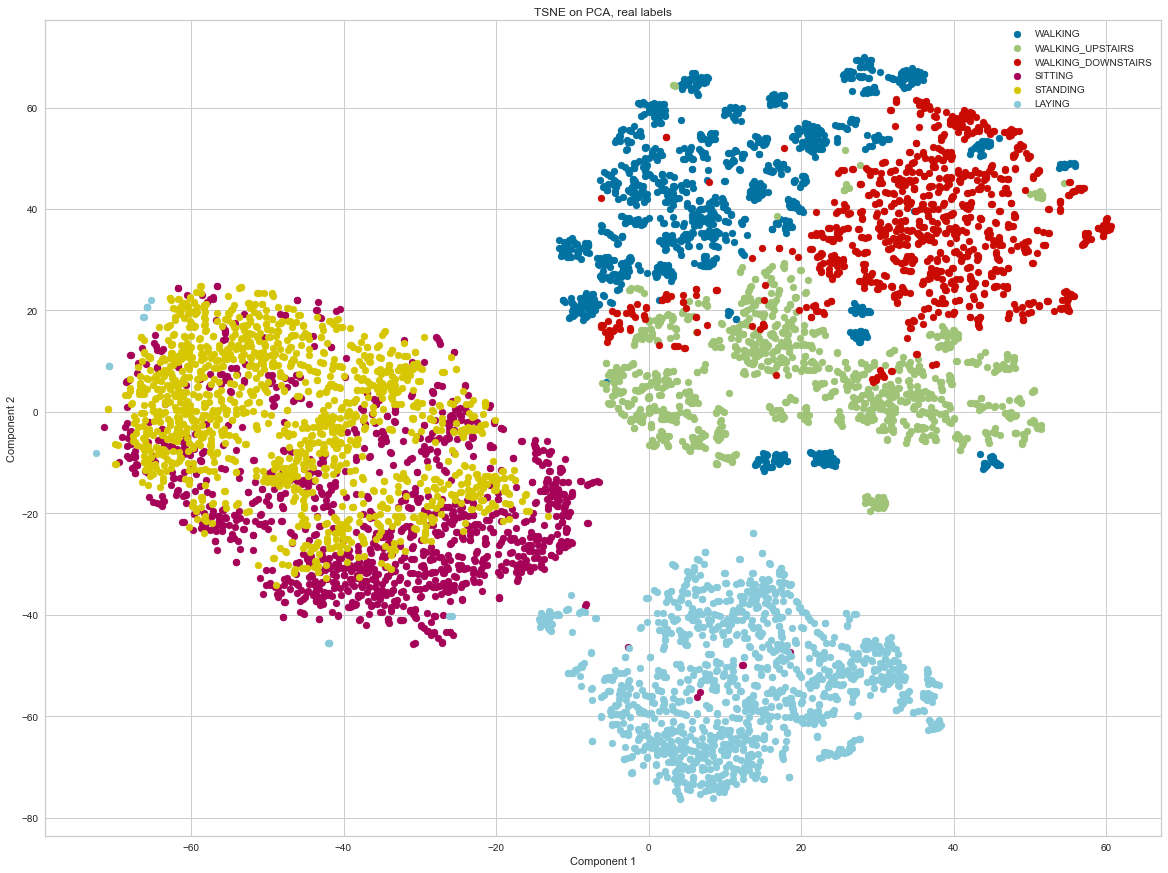

In [74]:
classes  = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]
plot_components("TSNE", best_tsne.embedding_, labels=y_train, comp=True, title=False,
                legend_labels=classes)
plt.title("TSNE on PCA, real labels")
plt.show()